In [216]:
import math
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import progressbar
import scipy.io as sio
from scipy.interpolate import UnivariateSpline
import seaborn as sns

from IPython.core.display import display, HTML
from mat_handler import import_scored_file_hdf5
from mat2py import mat2py
from skimage import transform
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
import sklearn.manifold
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

%matplotlib inline

In [2]:
labeled = pd.read_csv('rr_sane.csv')
labeled = labeled.drop('Unnamed: 0',1)

novel = pd.read_csv('novel_data.csv')
novel = novel.drop('Unnamed: 0',1)

# Introduction

Exocytic events of transmembrane receptors are readily visible using superecliptic pHluorin-tagged (SpH) cargo. Previously, our lab has used simple count analyses to look for changes in exocytic rate across a variety of manipulations. Although powerful, this analysis has not taken into account the massive heterogeneity that can be seen when comparing exocytic events either within or across different receptor cargos. We can see multiples types of events, such as events with a long plateau, bright fast events, and dim events:

In [ ]:
column_names = ['track','isPuff','f','x','y','c','A','original']

tfr_events = pd.DataFrame(import_scored_file_hdf5('/Volumes/Coatamer/Users/weinberz/CMU Drive/Data/Puffs Analysis/TfR Puffs/scoredTracksTfRZYWCell2.mat'),
                          columns = column_names)
b2_events = pd.DataFrame(import_scored_file_hdf5('/Volumes/Coatamer/Users/weinberz/CMU Drive/Data/Puffs Analysis/Rachel B2 Puffs/scoredTracksB2Cell3.mat'),
                         columns = column_names)
mor_events = pd.DataFrame(import_scored_file_hdf5('/Volumes/Coatamer/Users/weinberz/CMU Drive/Data/Puffs Analysis/2016 Washout Jenny/WTMOR/scoredTracksMORCell2.mat'),
                          columns = column_names)

def plot_track(events, track_num, start, end):
    y = events.loc[events['track'] == track_num, 'A'][start:end]
    x = np.arange(y.shape[0])*0.1
    plt.plot(x, y, label = str(track_num), marker="o")
    

Text(0.5,1,'TfR')

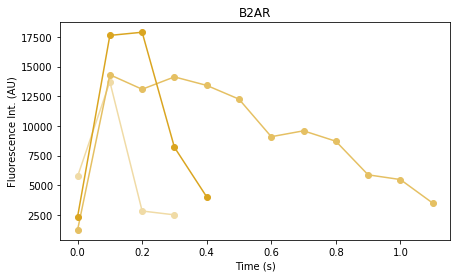

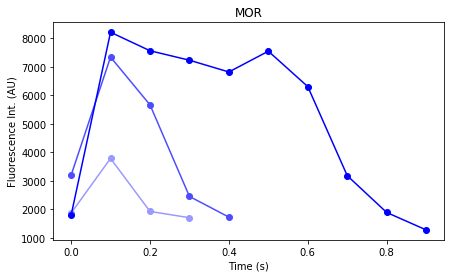

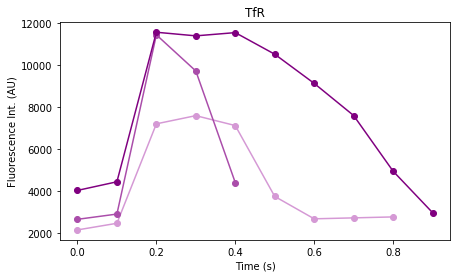

In [244]:
pal = sns.color_palette(np.array(sns.light_palette('goldenrod',10))[[3,6,9]])
sns.set_palette(pal)
plt.figure(figsize=(7,4))
plot_track(b2_events, 648, 0, -1)
plot_track(b2_events, 576, 0, -1)
plot_track(b2_events, 665, 0, -1)
plt.ylabel('Fluorescence Int. (AU)')
plt.xlabel('Time (s)')
plt.title('B2AR')

pal = sns.color_palette(np.array(sns.light_palette('blue',10))[[3,6,9]])
sns.set_palette(pal)
plt.figure(figsize=(7,4))
plot_track(mor_events, 351, 0, -1)
plot_track(mor_events, 295, 0, -1)
plot_track(mor_events, 138, 0, -1)
plt.ylabel('Fluorescence Int. (AU)')
plt.xlabel('Time (s)')
plt.title('MOR')

pal =  sns.color_palette(np.array(sns.light_palette('purple',10))[[3,6,9]])
sns.set_palette(pal)
plt.figure(figsize=(7,4))
plot_track(tfr_events, 81, 1, -1)
plot_track(tfr_events, 1057, 5, -1)
plot_track(tfr_events, 1062, 9, -1)
plt.ylabel('Fluorescence Int. (AU)')
plt.xlabel('Time (s)')
plt.title('TfR')

/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


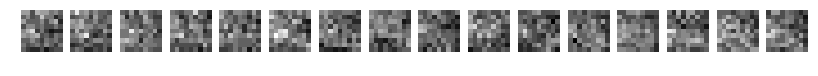

In [239]:
mor_puffs = np.load('MORCell2.npy')

columns = ['track', 'isPuff', 'frame', 'is_orig', 'x', 'y', 'A']
mor_puffs = pd.DataFrame(mor_puffs, columns = columns)
mor_puffs

def create_frame(rows):
    frame = np.zeros((81,1))
    rows = rows.reset_index()
    for ind, row in rows.iterrows():
        frame[ind] = row['A']
    
    return frame.reshape(9,9)

def plot_montage(track):
    track_frames = np.unique(track['frame'])
    vmin = np.min(track['A'])
    vmax = np.max(track['A'])
    nf = track_frames.shape[0]
    fig = plt.figure(figsize=(15,2))
    for frame_ind, frame_num in enumerate(track_frames):
        frame = create_frame(track.loc[track['frame'] == frame_num, :])
        frame = transform.rescale(frame, 1, anti_aliasing = False)
        fig.add_subplot(1, nf+1, frame_ind+1)
        plt.imshow(frame, cmap='gray', vmin = vmin, vmax = vmax)
        plt.axis('off')
        
plot_montage(mor_puffs.loc[(mor_puffs['track'] == 295), :])

Even if we manually split puffs into these distinct classes, we still lose out on a host of quantitative information. If we're looking for differences in exocytic events between cargo, this information is ideal for determining these differences. To establish whether there are quantitative differences between cargo, we first sought to look at differences between hand scored events. With this labeled dataset in hand, we were then able to build a machine learning classifier that could distinguish bona fide exocytic events from noise in novel movies without the need for manual scoring.

# Methods and Results

To simplify the process of detecting exocytic events, we made use of the detection portion of the cmeAnalysis package (Aguet et al. 2013) to detect diffraction limited spots in pre-existing exocytic recycling movies that we've recorded. This detection easily found bona fide events, but also identified many events in our movies that were clearly noise. To distinguish real events from noise, we hand scored over 30,000 events across 19 different cells for 3 different cargo. For cargo, we selected two model GPCRs of interest to our lab, the B2 adrenergic receptor and the mu opioid receptor. We also included the transferrin receptor in our analysis, as it is a clasically recycling cargo. The scored data set contains a total of 1300 exocytic events (467 B2AR, 218 MOR, 615 TfR). For our hand scored events, we evaluated the events on 4 quantitiative measures:

* lifetime: the duration over which the event occurs
* plateau: the time between initial event appearance before the receptor begins to diffuse into the cell membrane. We use this is a metric for the time an event spends before it the exocytic pore is fully open
* tau: the half-life of the event's decay after it's initial diffusion. We use this as a measurement of the rate of collapse or vesicle emptying into the plasma membrane
* integrated density: the total fluorescence value of the event over it's lifetime. This is a function of the bleaching rate of the cargo, the total amount of cargo in the event, and the diffusion rate of the cargo coming from the event.

When evaluated based on these criteria, distinctions in cargo populations can be clearly seen.

Text(0,0.5,'Density')

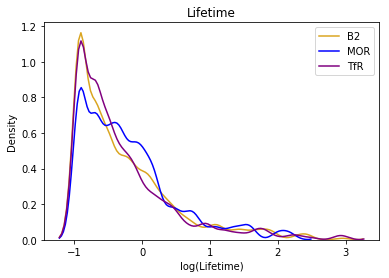

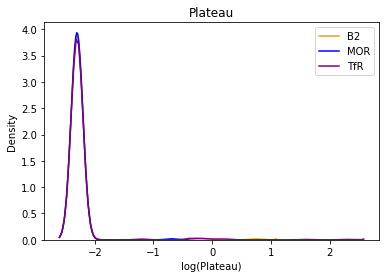

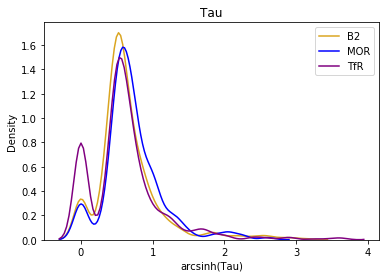

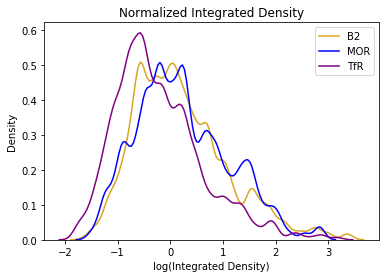

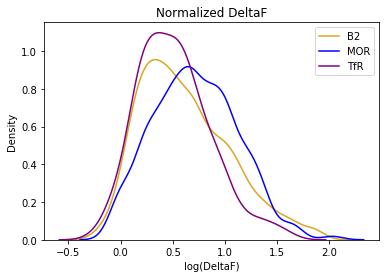

In [242]:
puff_pal = sns.color_palette(['goldenrod', 'blue', 'purple'])
sns.set_palette(puff_pal)

for cargo in ['B2', 'MOR', 'TfR']:
    sns.kdeplot(np.log(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'lifetime_s']), 
                label=cargo, 
                bw=0.1,
                shade = False)
    
plt.title('Lifetime')
plt.xlabel('log(Lifetime)')
plt.ylabel('Density')

plt.figure()

for cargo in ['B2', 'MOR', 'TfR']:
    sns.kdeplot(np.log(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'plateau']), 
                label=cargo, 
                bw=0.1,
                shade = False)
    
plt.title('Plateau')
plt.xlabel('log(Plateau)')
plt.ylabel('Density')

plt.figure()

for cargo in ['B2', 'MOR', 'TfR']:
    sns.kdeplot(np.arcsinh(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'tau']), 
                label=cargo, 
                bw=0.1,
                shade = False)
    
plt.title('Tau')
plt.xlabel('arcsinh(Tau)')
plt.ylabel('Density')

plt.figure()

for cargo in ['B2', 'MOR', 'TfR']:
    subset = labeled.loc[labeled['cargo'] == cargo, :]
    for cell in np.unique(subset['cell']):
        densities = subset.loc[subset['cell'] == cell, 'int_density']
        labeled.loc[(labeled['cargo'] == cargo) & (labeled['cell'] == cell), 'norm_density'] = densities/np.nanmean(densities)
    sns.kdeplot(np.log(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'norm_density']), 
                bw = 0.1, 
                label = cargo,
                shade = False)
    
plt.title('Normalized Integrated Density')
plt.xlabel('log(Integrated Density)')
plt.ylabel('Density')

plt.figure()

for cargo in ['B2', 'MOR', 'TfR']:
    subset = labeled.loc[labeled['cargo'] == cargo, :]
    for cell in np.unique(subset['cell']):
        deltafs = subset.loc[subset['cell'] == cell, 'deltaf']
        labeled.loc[(labeled['cargo'] == cargo) & (labeled['cell'] == cell), 'norm_deltaf'] = deltafs/np.nanmean(deltafs)
    sns.kdeplot(np.log(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'norm_deltaf']), 
                bw = 0.1, 
                label = cargo,
                shade = False)
    
plt.title('Normalized DeltaF')
plt.xlabel('log(DeltaF)')
plt.ylabel('Density')

All of these features are somwhat dependent on each other. Because of those dependencies, it is helpful to look at the relation of puffs in a dimensionally scaled space. To do this, we create compute a distance matrix. Here we used two potential methods, MDS and tSNE.

In [132]:
puffs_for_ds = labeled.loc[labeled['isPuff'] == 1., ['cargo', 'lifetime_s', 'plateau', 'tau', 'int_density', 'deltaf']]

scaled_puffs = preprocessing.scale(puffs_for_ds[['lifetime_s', 'plateau', 'tau', 'int_density', 'deltaf']])

mds_class = sklearn.manifold.MDS(random_state=237)
fit_mds = mds_class.fit_transform(scaled_puffs)

tsne_class = sklearn.manifold.TSNE(random_state=237)
fit_tsne = tsne_class.fit_transform(scaled_puffs)

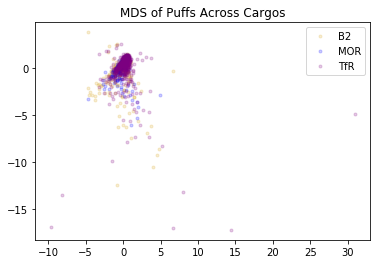

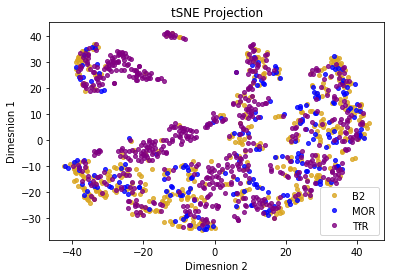

In [271]:
puff_pal = sns.color_palette(['goldenrod', 'blue', 'purple'])
sns.set_palette(puff_pal)

plt.figure()

plt.title('MDS of Puffs Across Cargos')
for cargo in ['B2','MOR','TfR']:
    filt = (puffs_for_ds['cargo'] == cargo)
    plt.plot(fit_mds[filt,0],
             fit_mds[filt,1],
             marker='.', ls='None', alpha = .2, label=cargo)
plt.legend()

plt.figure()

plt.title('tSNE Projection')
for cargo in ['B2','MOR','TfR']:
    filt = (puffs_for_ds['cargo'] == cargo)
    plt.plot(fit_tsne[filt,0],
             fit_tsne[filt,1],
             marker='o', markersize='4', ls='None', alpha = .8, label=cargo)
    plt.xlabel('Dimesnion 2')
    plt.ylabel('Dimesnion 1')
plt.legend()

## Training a machine learning classifier to identify exocytic events

The above differences in cargo are suggestive of different pools of exocytic vesicles, perhaps originating from distinct endosomal locations. In order to test this hypothesis, it is important to gather a large dataset in every condition. This is limiting given the time consuming nature of identifying single exocytic events. To allow more rapid acquisition of data across various conditions, we engineered features from the scored dataset. The features we engineered separated bona fide exocytic events from the large amount of noise identified during initial point detection. 

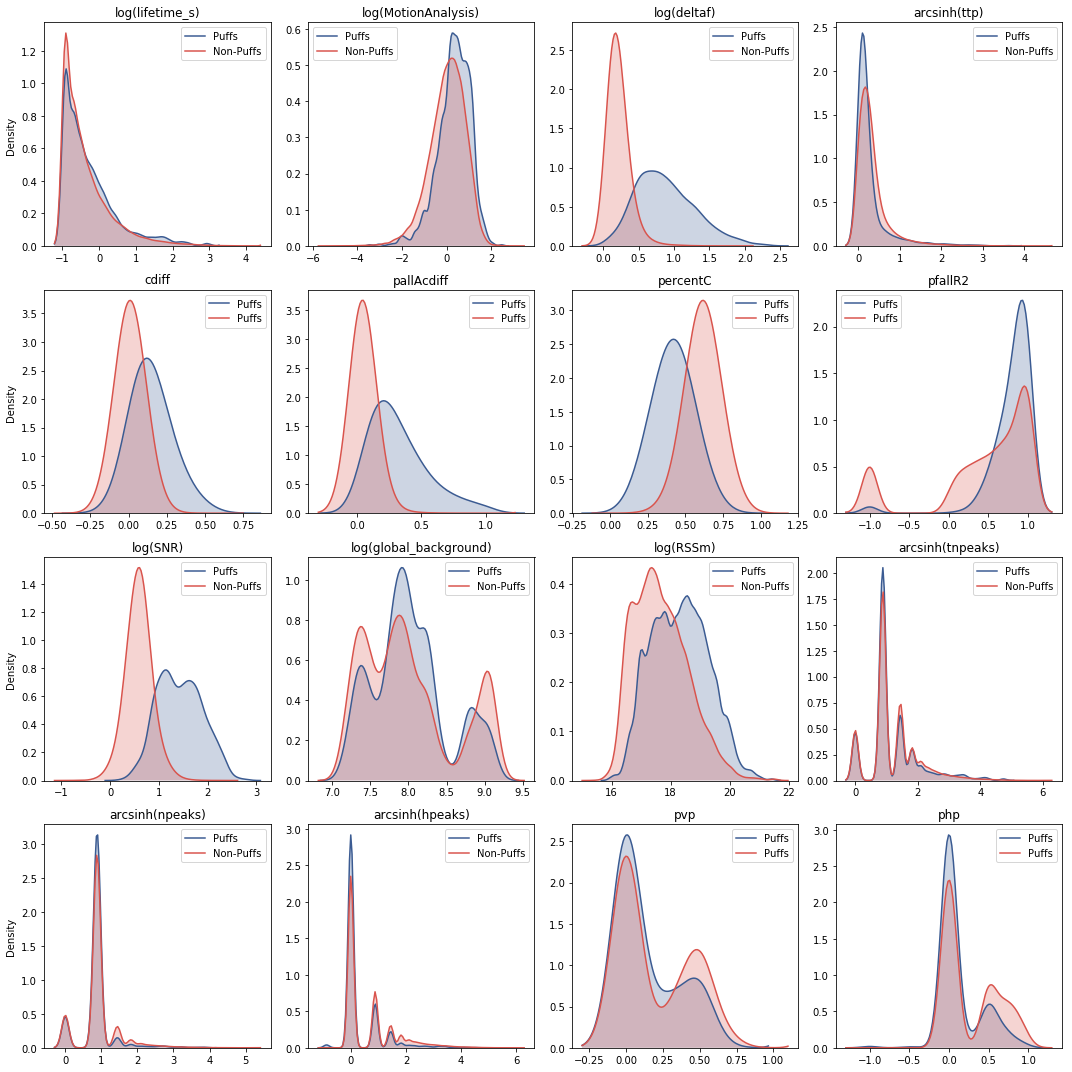

In [256]:
training_fields = ['lifetime_s', 'MotionAnalysis', 'deltaf', 'ttp', 'cdiff', 'pallAcdiff',
                    'percentC', 'pfallR2', 'SNR', 'global_background', 'RSSm',
                    'tnpeaks', 'npeaks', 'hpeaks', 'pvp', 'php']


sns.set_palette(sns.color_palette([sns.xkcd_rgb['denim blue'], sns.xkcd_rgb['pale red']]))

fig, axes = plt.subplots(math.ceil(np.shape(training_fields)[0]/4),
                         4)
fig.set_size_inches(15,15)

for counter, feature in enumerate(training_fields):
    if  counter % 4 == 0:
        axes.ravel()[counter].set_ylabel('Density ')
    axes.ravel()[counter].set_title(feature)
    dist = labeled[feature]
    puff_dist = dist[labeled['isPuff'] == 1.]
    nonpuff_dist = dist[labeled['isPuff'] == 2.]
    dist = dist[~np.isnan(dist)]
    puff_dist = puff_dist[~np.isnan(puff_dist)]
    nonpuff_dist = nonpuff_dist[~np.isnan(nonpuff_dist)]
    
    if (np.max(dist) > 1):
        if np.any(dist <= 0):
            sns.kdeplot(np.arcsinh(puff_dist), 
                        label = 'Puffs',
                        bw = 0.1,
                        shade = True,
                        ax = axes.ravel()[counter]).set_title('arcsinh(' + feature + ')')
            sns.kdeplot(np.arcsinh(nonpuff_dist), 
                        label = 'Non-Puffs',
                        bw = 0.1,
                        shade = True,
                        ax = axes.ravel()[counter]).set_title('arcsinh(' + feature + ')')
        else:
            sns.kdeplot(np.log(puff_dist), 
                        label = 'Puffs',
                        bw = 0.1,
                        shade = True,
                        ax = axes.ravel()[counter]).set_title('log(' + feature + ')')
            sns.kdeplot(np.log(nonpuff_dist), 
                        label = 'Non-Puffs',
                        bw = 0.1,
                        shade = True,
                        ax = axes.ravel()[counter]).set_title('log(' + feature + ')')
    else:
        sns.kdeplot(puff_dist, 
                     label = 'Puffs',
                     bw = 0.1,
                        shade = True,
                     ax = axes.ravel()[counter])
        sns.kdeplot(nonpuff_dist, 
                     label = 'Puffs',
                     bw = 0.1,
                        shade = True,
                     ax = axes.ravel()[counter])

plt.tight_layout()

After building features, we selected a RandomForest machine learning algorithm in order to build our classifier. To evaluate the performance of our model, we used a round robin design - for each classifier in the dataset, we build a classifier trained on all other cells in the labeled dataset, and then evaluated it against the held out cell.

<function matplotlib.pyplot.show>

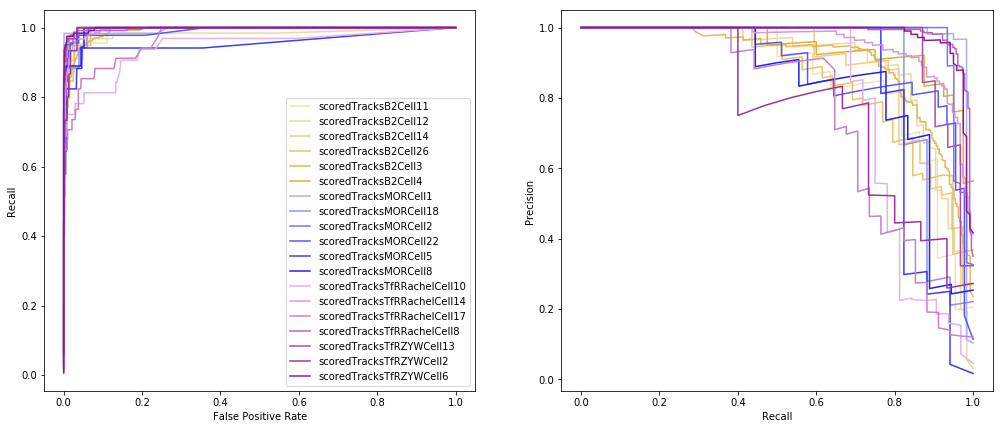

In [144]:
pal = sns.light_palette('goldenrod',9)[2:-1] + sns.light_palette('blue',9)[2:-1] + sns.light_palette('purple',10)[2:-1]
sns.set_palette(pal)

plt.figure(figsize=(17,7))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

for cell in np.unique(labeled['cell']):
    held_data = labeled.loc[labeled['cell'] == cell]
    train_data = labeled.loc[labeled['cell'] != cell]
    classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=4)
    classifier.fit(train_data[training_fields], train_data['isPuff'])
    probas_ = classifier.predict_proba(held_data[training_fields])
    fpr, tpr , thresholds= roc_curve(held_data['isPuff'], probas_[:,0], pos_label = 1)
    ax1.plot(fpr, tpr, label=cell)
    precision, recall, thresholds = precision_recall_curve(held_data['isPuff'], probas_[:,0],pos_label = 1)
    ax2.plot(recall, precision, label=cell)
                             
ax1.legend()
plt.show

Given reasonable performance on each individual cell in the dataset, we then built a classifier to evaluate new data based on the entirety of labeled data. We can look at the out of bag data from the classifier to measure performance of the new classifer across specific cargo. We also want to calibrate the output probabilities for any new cells based on the actual scores of the classifier. Therefore we train a calibrater (basically, logistic regression) on the classifier OOB.

In [272]:
classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=4)
classifier.fit(labeled[training_fields], labeled['isPuff'])

calibrater = LogisticRegression(C = 1000000, random_state=237)
calibrater.fit(classifier.oob_decision_function_[:,0].reshape(-1, 1), labeled['isPuff'])

order = np.argsort(-classifier.feature_importances_)
for ind in order:
    print(training_fields[ind] + '\t' + str(classifier.feature_importances_[ind]))

deltaf	0.2800942899996863
pallAcdiff	0.18250790317622398
SNR	0.16461866546997111
percentC	0.12506633781508603
cdiff	0.09967191830066204
pfallR2	0.028262505471400554
RSSm	0.021154779466978725
php	0.016980029253666578
global_background	0.014868759827262105
ttp	0.013923228406396001
MotionAnalysis	0.012588367346057838
lifetime_s	0.01243456633026725
hpeaks	0.012418241966821592
tnpeaks	0.007031747193979956
npeaks	0.004549121018261648
pvp	0.003829538957278774


We can then calibrate the OOB properties and look to see what our performance looks like on the OOB data by evaluating on a per cargo basis

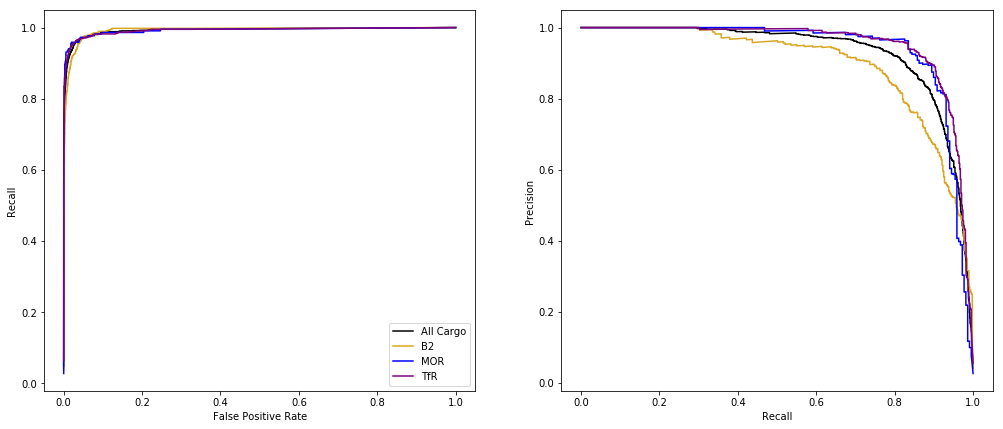

In [275]:
plt.figure(figsize=(17,7))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

puff_pal = sns.color_palette(['black','goldenrod', 'blue', 'purple'])
sns.set_palette(puff_pal)

probas = calibrater.predict_proba(classifier.oob_decision_function_[:, 0].reshape(-1, 1))[:,0]
fpr, tpr , thresholds= roc_curve(labeled['isPuff'], probas, pos_label = 1)
ax1.plot(fpr, tpr, label='All Cargo')
precision, recall, thresholds = precision_recall_curve(labeled['isPuff'], probas, pos_label = 1)
ax2.plot(recall, precision, label='All Cargo')

for cargo in np.unique(labeled['cargo']):
    probas = classifier.oob_decision_function_[labeled['cargo'] == cargo, 0]
    fpr, tpr , thresholds= roc_curve(labeled.loc[labeled['cargo'] == cargo,'isPuff'], probas, pos_label = 1)
    ax1.plot(fpr, tpr, label=cargo)
    precision, recall, thresholds = precision_recall_curve(labeled.loc[labeled['cargo'] == cargo,'isPuff'], probas, pos_label = 1)
    ax2.plot(recall, precision, label=cargo)
    
ax1.legend()

Given the variable performance across different datasets, it's important to select a threshold for each cargo such that our performance is approximately the same across all cargos. Values were selected such that all cargos had similar recall and false positive rates, with a bit of variability in precision.

In [223]:
cargo = 'B2'
probas = classifier.oob_decision_function_[labeled['cargo'] == cargo, 0]
fpr, tpr , thresholds1 = roc_curve(labeled.loc[labeled['cargo'] == cargo,'isPuff'], probas, pos_label = 1)
precision, recall, thresholds2 = precision_recall_curve(labeled.loc[labeled['cargo'] == cargo,'isPuff'], probas, pos_label = 1)

i = 1825
thresh = thresholds2[i]
j = np.abs(thresholds1 - thresh).argmin()
[precision[i], recall[i], thresholds2[i], fpr[j], tpr[j], thresholds1[j]]

[0.9056603773584906,
 0.7194860813704497,
 0.5682451253481894,
 0.0031003631854017184,
 0.721627408993576,
 0.5674157303370787]

In [225]:
cargo = 'MOR'
probas = classifier.oob_decision_function_[labeled['cargo'] == cargo, 0]
fpr, tpr , thresholds1 = roc_curve(labeled.loc[labeled['cargo'] == cargo,'isPuff'], probas, pos_label = 1)
precision, recall, thresholds2 = precision_recall_curve(labeled.loc[labeled['cargo'] == cargo,'isPuff'], probas, pos_label = 1)

i = 1175
thresh = thresholds2[i]
j = np.abs(thresholds1 - thresh).argmin()
[precision[i], recall[i], thresholds2[i], fpr[j], tpr[j], thresholds1[j]]

[0.9751552795031055,
 0.7201834862385321,
 0.7538071065989848,
 0.0005062009617818274,
 0.6972477064220184,
 0.776183644189383]

In [224]:
cargo = 'TfR'
probas = classifier.oob_decision_function_[labeled['cargo'] == cargo, 0]
fpr, tpr , thresholds1 = roc_curve(labeled.loc[labeled['cargo'] == cargo,'isPuff'], probas, pos_label = 1)
precision, recall, thresholds2 = precision_recall_curve(labeled.loc[labeled['cargo'] == cargo,'isPuff'], probas, pos_label = 1)

i = 1535
thresh = thresholds2[i]
j = np.abs(thresholds1 - thresh).argmin()
[precision[i], recall[i], thresholds2[i], fpr[j], tpr[j], thresholds1[j]]

[0.977924944812362,
 0.7203252032520325,
 0.6624472573839663,
 0.0009517464547444561,
 0.7203252032520325,
 0.6624472573839663]

## Evaluating new data on the classifier
With a trained classifier, we can now detect puffs in a novel data set. We selected previously generated exocytosis recordings from each of the evaluated cargo (59 cells for B2AR, 20 cells for MOR, 19 cells for TfR) and evaluated them on the classifier, thresholding based on the above to select for detected events that are likely to be puffs.

In [247]:
novel['probas'] = classifier.predict_proba(novel[training_fields])[:,0]

In [248]:
novel.loc[:,'isPuff'] = 2.

for cargo, thresh in {'B2' : 0.56, 'MOR' : 0.75, 'TfR' : 0.66}.items():
    filt = (novel['cargo'] == cargo) & (novel['probas'] > thresh)
    novel.loc[filt, 'isPuff'] = 1.

Text(0.5,0.98,'Normalized DeltaF')

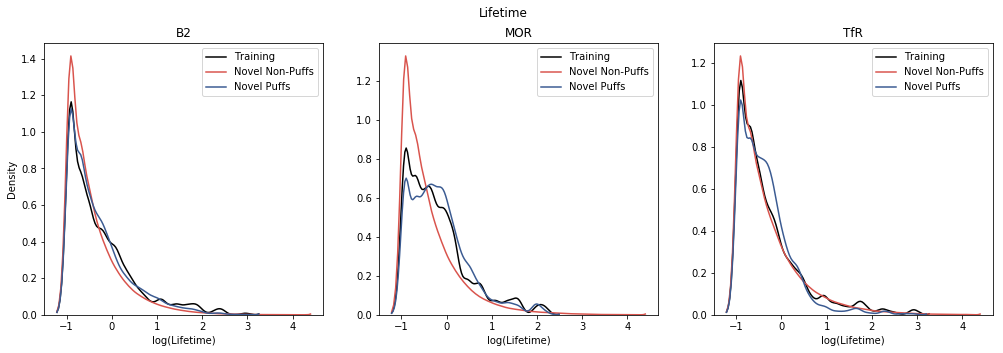

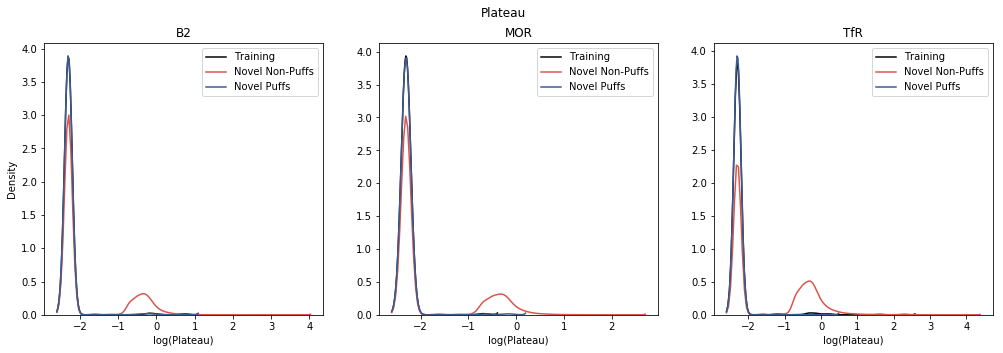

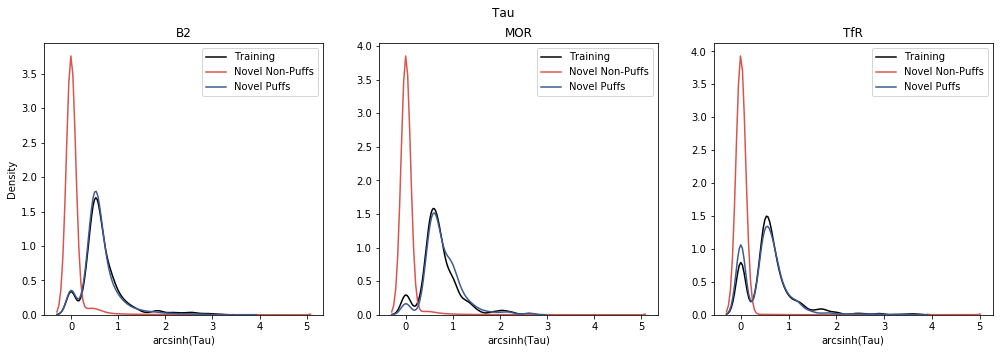

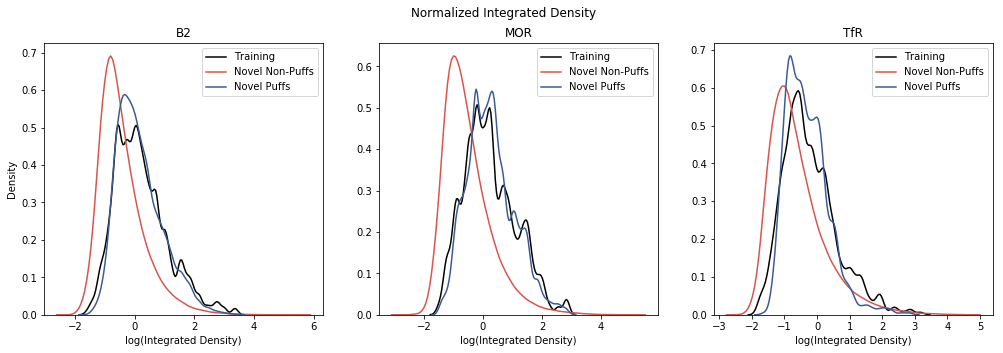

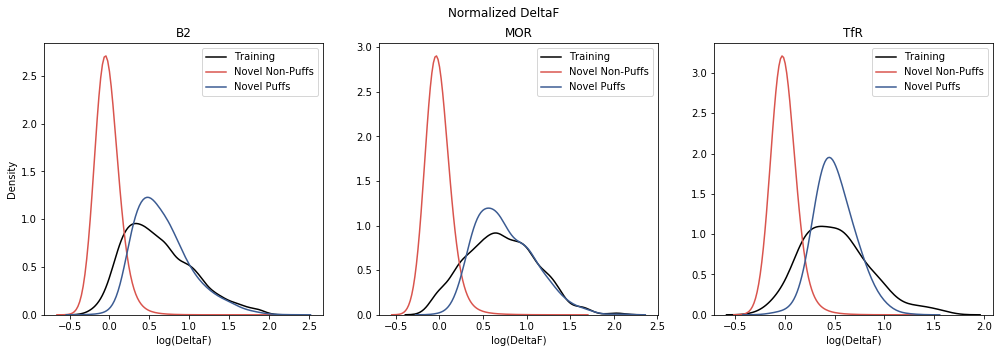

In [270]:
puff_pal = sns.color_palette(['black', sns.xkcd_rgb['pale red'], sns.xkcd_rgb['denim blue']])
sns.set_palette(puff_pal)

fig, ax = plt.subplots(1,3,figsize=(17,5))

for axis, cargo in enumerate(['B2', 'MOR', 'TfR']):
    sns.kdeplot(np.log(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'lifetime_s']), ax=ax[axis], label='Training', bw=0.1)
    sns.kdeplot(np.log(novel.loc[(novel['cargo'] == cargo) & (novel['isPuff'] != 1.), 'lifetime_s']), ax=ax[axis], label='Novel Non-Puffs', bw=0.1)
    sns.kdeplot(np.log(novel.loc[(novel['cargo'] == cargo) & (novel['isPuff'] == 1.), 'lifetime_s']), ax=ax[axis], label='Novel Puffs', bw=0.1)
    ax[axis].set_title(cargo)
    ax[axis].set_xlabel('log(Lifetime)')
    if axis == 0:
        ax[axis].set_ylabel('Density')

plt.suptitle('Lifetime')
    
fig, ax = plt.subplots(1,3,figsize=(17,5))

for axis, cargo in enumerate(['B2', 'MOR', 'TfR']):
    sns.kdeplot(np.log(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'plateau']), ax=ax[axis], label='Training', bw=0.1)
    sns.kdeplot(np.log(novel.loc[(novel['cargo'] == cargo) & (novel['isPuff'] != 1.), 'plateau']), ax=ax[axis], label='Novel Non-Puffs', bw=0.1)
    sns.kdeplot(np.log(novel.loc[(novel['cargo'] == cargo) & (novel['isPuff'] == 1.), 'plateau']), ax=ax[axis], label='Novel Puffs', bw=0.1)
    ax[axis].set_title(cargo)
    ax[axis].set_xlabel('log(Plateau)')
    if axis == 0:
        ax[axis].set_ylabel('Density')
    
plt.suptitle('Plateau')

fig, ax = plt.subplots(1,3,figsize=(17,5))

for axis, cargo in enumerate(['B2', 'MOR', 'TfR']):
    sns.kdeplot(np.arcsinh(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'tau']), ax=ax[axis], label='Training', bw=0.1)
    sns.kdeplot(np.arcsinh(novel.loc[(novel['cargo'] == cargo) & (novel['isPuff'] != 1.), 'tau']), ax=ax[axis], label='Novel Non-Puffs', bw=0.1)
    sns.kdeplot(np.arcsinh(novel.loc[(novel['cargo'] == cargo) & (novel['isPuff'] == 1.), 'tau']), ax=ax[axis], label='Novel Puffs', bw=0.1)
    ax[axis].set_title(cargo)
    ax[axis].set_xlabel('arcsinh(Tau)')
    if axis == 0:
        ax[axis].set_ylabel('Density')
    
    
plt.suptitle('Tau')

fig, ax = plt.subplots(1,3,figsize=(17,5))

for axis, cargo in enumerate(['B2', 'MOR', 'TfR']):
    subset = novel.loc[novel['cargo'] == cargo, :]
    for cell in np.unique(subset['cell']):
        densities = subset.loc[subset['cell'] == cell, 'int_density']
        novel.loc[(novel['cargo'] == cargo) & (novel['cell'] == cell), 'norm_density'] = densities/np.nanmean(densities)
    sns.kdeplot(np.log(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'norm_density']), ax=ax[axis], label='Training', bw=0.1)
    sns.kdeplot(np.log(novel.loc[(novel['cargo'] == cargo) & (novel['isPuff'] != 1.), 'norm_density']), ax=ax[axis], label='Novel Non-Puffs', bw=0.1)
    sns.kdeplot(np.log(novel.loc[(novel['cargo'] == cargo) & (novel['isPuff'] == 1.), 'norm_density']), ax=ax[axis], label='Novel Puffs', bw=0.1)
    ax[axis].set_xlabel('log(Integrated Density)')
    ax[axis].set_title(cargo)
    
    if axis == 0:
        ax[axis].set_ylabel('Density')
    
    
plt.suptitle('Normalized Integrated Density')

fig, ax = plt.subplots(1,3,figsize=(17,5))

for axis, cargo in enumerate(['B2', 'MOR', 'TfR']):
    subset = novel.loc[novel['cargo'] == cargo, :]
    for cell in np.unique(subset['cell']):
        deltaf = subset.loc[subset['cell'] == cell, 'deltaf']
        novel.loc[(novel['cargo'] == cargo) & (novel['cell'] == cell), 'norm_deltaf'] = deltaf/np.nanmean(deltaf)
    sns.kdeplot(np.log(labeled.loc[(labeled['cargo'] == cargo) & (labeled['isPuff'] == 1.), 'norm_deltaf']), ax=ax[axis], label='Training', bw=0.1)
    sns.kdeplot(np.log(novel.loc[(novel['cargo'] == cargo) & (novel['isPuff'] != 1.), 'norm_deltaf']), ax=ax[axis], label='Novel Non-Puffs', bw=0.1)
    sns.kdeplot(np.log(novel.loc[(novel['cargo'] == cargo) & (novel['isPuff'] == 1.), 'norm_deltaf']), ax=ax[axis], label='Novel Puffs', bw=0.1)
    ax[axis].set_title(cargo)
    ax[axis].set_xlabel('log(DeltaF)')
    if axis == 0:
        ax[axis].set_ylabel('Density')
    
plt.suptitle('Normalized DeltaF')